In [35]:
import sqlite3
import random
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
conn = sqlite3.connect('optimised_sum_indices.db')
cursor = conn.cursor()

In [26]:
print("\n1. Table Structure:")
cursor.execute("PRAGMA table_info(sum_indices)")
table_info = cursor.fetchall()
print(pd.DataFrame(table_info, columns=['cid', 'name', 'type', 'notnull', 'dflt_value', 'pk']))


1. Table Structure:
   cid     name  type  notnull dflt_value  pk
0    0      sum  REAL        0       None   0
1    1  indices  BLOB        0       None   0


In [27]:
print("\n2. Count of Rows:")
cursor.execute("SELECT COUNT(*) FROM sum_indices")
row_count = cursor.fetchone()[0]
print(f"Total number of rows (unique sums): {row_count}")


2. Count of Rows:
Total number of rows (unique sums): 16105429


In [28]:
print("\n3. Sample Data:")
cursor.execute("SELECT sum, length(indices) as indices_length FROM sum_indices LIMIT 5")
sample_data = cursor.fetchall()
print(pd.DataFrame(sample_data, columns=['Sum', 'Indices Length']))


3. Sample Data:
          Sum  Indices Length
0  25448932.0               8
1  25211168.0               8
2  27177416.0               8
3  29895276.0               8
4  29657512.0               8


In [29]:
print("\n4. Distribution of Subset Counts:")
cursor.execute("""
    SELECT 
        length(indices)/4 as subset_count, 
        COUNT(*) as frequency
    FROM sum_indices 
    GROUP BY subset_count 
    ORDER BY subset_count
    LIMIT 10
""")
distribution = cursor.fetchall()
print(pd.DataFrame(distribution, columns=['Subset Count', 'Frequency']))


4. Distribution of Subset Counts:
   Subset Count  Frequency
0             2     889196
1             3     648736
2             4     518911
3             5     440123
4             6     388557
5             7     354823
6             8     327347
7             9     306635
8            10     290221
9            11     274915


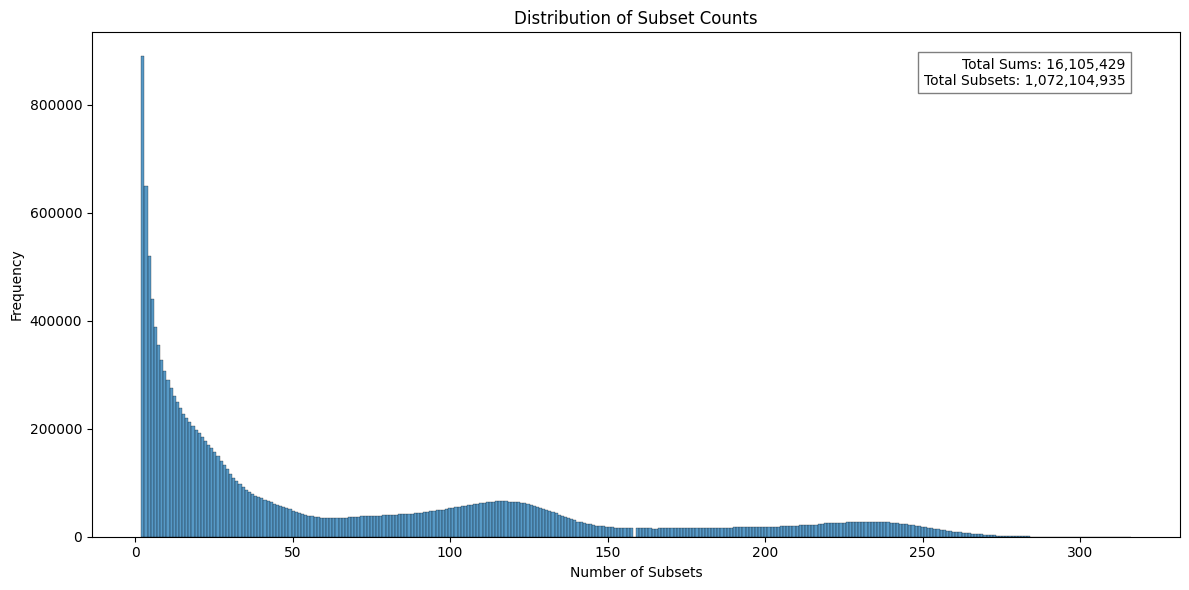

In [42]:
# Query to get the distribution of subset counts
cursor.execute("""
    SELECT 
        length(indices)/4 as subset_count, 
        COUNT(*) as frequency
    FROM sum_indices 
    GROUP BY subset_count 
    ORDER BY subset_count
""")

# Fetch all results
distribution = cursor.fetchall()

# Convert to DataFrame
df = pd.DataFrame(distribution, columns=['Subset Count', 'Frequency'])

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Subset Count', weights='Frequency', bins=316, kde=False)

plt.title('Distribution of Subset Counts')
plt.xlabel('Number of Subsets')
plt.ylabel('Frequency')

# Add text with total sums and subsets
total_sums = df['Frequency'].sum()
total_subsets = (df['Subset Count'] * df['Frequency']).sum()
plt.text(0.95, 0.95, f'Total Sums: {total_sums:,}\nTotal Subsets: {total_subsets:,}', 
         transform=plt.gca().transAxes, ha='right', va='top', 
         bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

In [30]:
print("\n5. Sums with Most Subsets:")
cursor.execute("""
    SELECT sum, length(indices)/4 as subset_count
    FROM sum_indices 
    ORDER BY subset_count DESC
    LIMIT 5
""")
most_subsets = cursor.fetchall()
print(pd.DataFrame(most_subsets, columns=['Sum', 'Subset Count']))


5. Sums with Most Subsets:
          Sum  Subset Count
0  92716336.0           316
1  91819776.0           313
2  90175248.0           313
3  92231216.0           312
4  93278112.0           311


In [31]:
print("\n6. Total Number of Subsets:")
cursor.execute("SELECT SUM(length(indices)/4) FROM sum_indices")
total_subsets = cursor.fetchone()[0]
print(f"Total number of subsets across all sums: {total_subsets}")


6. Total Number of Subsets:
Total number of subsets across all sums: 1072104935


In [32]:
1073741823 - 1072104935

1636888

In [33]:
17742317 - 16105429

1636888

In [34]:
def sample_data(sample_size=10):
    # Get total number of rows
    cursor.execute("SELECT COUNT(*) FROM sum_indices")
    total_rows = cursor.fetchone()[0]
    
    # Generate random row numbers
    random_rows = random.sample(range(total_rows), min(sample_size, total_rows))
    
    samples = []
    for row_num in random_rows:
        cursor.execute(f"SELECT sum, length(indices)/4 as subset_count, indices FROM sum_indices LIMIT 1 OFFSET {row_num}")
        sum_val, subset_count, indices_blob = cursor.fetchone()
        
        # Decode indices efficiently using NumPy
        indices_array = np.frombuffer(indices_blob, dtype=np.uint32).byteswap()
        
        samples.append({
            'Sum': sum_val,
            'Subset Count': subset_count,
            'Sample Indices': indices_array[:5].tolist()  # Show first 5 indices
        })
    
    return pd.DataFrame(samples)

sample_df = sample_data(10)
print(sample_df)

           Sum  Subset Count  \
0  143443920.0             3   
1   60103636.0            24   
2   45082696.0             8   
3   61316200.0            42   
4  118190672.0            84   
5   61483480.0            24   
6   61212088.0            27   
7   60294436.0            13   
8   94313456.0           242   
9   47784428.0             4   

                                      Sample Indices  
0                [746454751, 1018691279, 1056047085]  
1  [7779344, 19077777, 21827141, 101167361, 11744...  
2  [7353424, 35686939, 39389268, 47384081, 100741...  
3  [18092650, 20221060, 24193171, 25837972, 26747...  
4  [32471847, 75348671, 110556923, 114712500, 120...  
5  [5645426, 109063371, 138635649, 147456253, 161...  
6  [3064963, 27708480, 35266866, 52281476, 72361748]  
7  [18407690, 72352999, 88343907, 145008384, 1689...  
8  [1945333, 19807802, 28096180, 28195964, 37155998]  
9         [19440133, 54691877, 138482013, 281102603]  


In [43]:
conn.close()
print("\nDatabase connection closed.")


Database connection closed.
